In [1]:
import pandas as pd
import numpy as np



In [2]:
# load dataset
df = pd.read_parquet('../data/train-00000-of-00001-3d14582ea46e1b17.parquet')



In [3]:
# print first 5 rows of dataset
df.head()


,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
# transform dataset to ascii
from unidecode import unidecode

df_ascii = df.applymap(unidecode)


df_ascii.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ca alors !


In [5]:
# save the ascii dataset
df_ascii.to_parquet('../data/train-00000-of-00001-3d14582ea46e1b17-ascii.parquet')


In [6]:
# max length of a cell:
print(df_ascii.applymap(len).max().max())


325


In [7]:
# melted dataset
df_melted = df_ascii.melt(var_name='language', value_name='text')

df_melted.head()


,language,text
0,English words/sentences,Hi.
1,English words/sentences,Run!
2,English words/sentences,Run!
3,English words/sentences,Who?
4,English words/sentences,Wow!


In [8]:
# save the melted dataset
df_melted.to_parquet('../data/train-00000-of-00001-3d14582ea46e1b17-ascii-melted.parquet')


In [9]:
# length of the melted dataset
print(len(df_melted))


350932


In [10]:
# tokenize the text, character to integers
chars = sorted(list(set(''.join(df_melted['text']))))
# add unknown character
chars.append('UNK')


print(''.join(chars))


 !"$%&'()+,-./0123456789:;<>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzUNK


In [11]:
def encode_text(text: str) -> list:
    return [chars.index(c) if c in chars else chars.index('UNK') for c in text]

def decode_text(encoded_text: list) -> str:
    return ''.join([chars[c] for c in encoded_text])

print(encode_text('Salut tout le monde. '))
print(decode_text(encode_text('hello world')))




[47, 55, 66, 75, 74, 0, 74, 69, 75, 74, 0, 66, 59, 0, 67, 69, 68, 58, 59, 12, 0]
hello world


In [87]:
import tensorflow as tf
from keras import layers

layers = tf.keras.layers
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0  # check if embed_dim is divisible by num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

        self.attention_weights = None

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True) # (batch_size, seq_len, seq_len)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # scalar value of the last dimension of key
        #scale the score to avoid the gradient vanishing problem
        scaled_score = score / tf.math.sqrt(dim_key) # (batch_size, seq_len, seq_len) / scalar
        weights = tf.nn.softmax(scaled_score, axis=-1) # (batch_size, seq_len, seq_len)

        output = tf.matmul(weights, value)
        # (batch_size, seq_len, seq_len) * (batch_size, num_heads, seq_len, embed_dim/num_heads) = (batch_size, num_heads, seq_len, embed_dim/num_heads)
        self.attention_weights = weights

        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.embed_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)
        value = self.separate_heads(value, batch_size)  # (batch_size, num_heads, seq_len, embed_dim/num_heads)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, embed_dim/num_heads)
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(concat_attention)  # (batch_size, seq_len, embed_dim)

        return output






In [88]:
from dataclasses import dataclass
block_size = 16 # 8 characters per block

@dataclass
class Config:
    block_size: int = block_size
    vocab_size: int = len(chars)
    n_head: int = 8
    n_embd: int = 32
    dropout: float = 0.0
    bias: bool = False # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

config = Config()


In [89]:
batch_size = 32

# define the model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D


model = Sequential([
    Embedding(input_dim=len(chars)+1, output_dim=config.n_embd, input_length=block_size),
    MultiHeadSelfAttention(config.n_embd, config.n_head),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', input_shape=(config.n_head,)),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

model.build(input_shape=(batch_size, block_size, config.n_embd))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 16, 32)            2656      
                                                                 
 multi_head_self_attention_7  (None, None, 32)         4224      
  (MultiHeadSelfAttention)                                       
                                                                 
 global_average_pooling1d_6   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_53 (Dense)            (None, 128)               4224      
                                                                 
 dense_54 (Dense)            (None, 128)               16512     
                                                                 
 dense_55 (Dense)            (None, 2)                

In [90]:
cost = 'categorical_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

model.compile(loss=cost, optimizer=optimizer, metrics=metrics)


In [91]:
from keras_preprocessing.sequence import pad_sequences

# Convert to list first
x = df_melted['text'].apply(encode_text).apply(lambda x: x[:block_size]).to_list()

# Pad sequences
x = pad_sequences(x, maxlen=block_size, padding='post', truncating='post')

y = pd.get_dummies(df_melted['language']).values  # convert DataFrame into a NumPy array

model.fit(
    x=x,
    y=y,
    batch_size=32,
    epochs=3,
    validation_split=0.2
)

Epoch 1/3
8774/8774 [==============================] - 22s 2ms/step - loss: 0.1388 - accuracy: 0.9439 - val_loss: 0.1640 - val_accuracy: 0.9288
Epoch 2/3
8774/8774 [==============================] - 20s 2ms/step - loss: 0.1117 - accuracy: 0.9560 - val_loss: 0.1794 - val_accuracy: 0.9361
Epoch 3/3
8774/8774 [==============================] - 20s 2ms/step - loss: 0.1011 - accuracy: 0.9599 - val_loss: 0.1469 - val_accuracy: 0.9551


In [92]:
# with 8 block_size:
# Epoch 3/3
# 8774/8774 [==============================] - 11s 1ms/step - loss: 0.0793 - accuracy: 0.9702 - val_loss: 0.1668 - val_accuracy: 0.9373

# with 16 block_size:
# 8774/8774 [==============================] - 20s 2ms/step - loss: 0.1015 - accuracy: 0.9599 - val_loss: 0.1506 - val_accuracy: 0.9464
print(x.shape)

(350932, 16)


In [93]:

# test the model on my own text
my_text = 'theatre de la vil'
my_text_encoded = encode_text(my_text)
my_text_encoded = pad_sequences([my_text_encoded], maxlen=block_size, padding='post', truncating='post')

print(my_text_encoded)

if np.argmax(model.predict(my_text_encoded)) == 1:
    print('French')
else:
    print('English')

[[74 62 59 55 74 72 59  0 58 59  0 66 55  0 76 63]]
1/1 [==============================] - 0s 71ms/step
English


(16, 16)


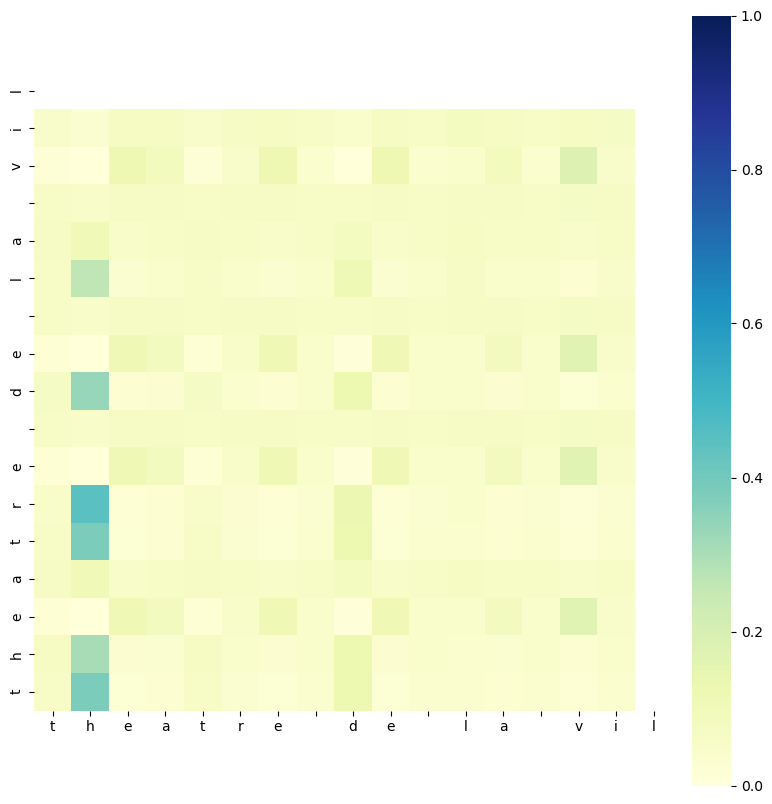

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns


prediction = model(my_text_encoded)

plt.figure(figsize=(10,10))
attention_weights = model.layers[1].attention_weights[0, 1].numpy()
print(attention_weights.shape)

labels= [char for char in my_text]
ax = sns.heatmap(attention_weights, square=True, vmin=0.0, vmax=1.0, cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
ax.invert_yaxis()
plt.show()
